## Python data science tools for petroleum exploration and production

This notebook goes with the blog post: [Visual data exploration in Python – correlation, confidence, spuriousness](https://mycarta.wordpress.com/2019/03/17/visual-data-exploration-in-python-correlation-confidence-spuriousness/).

## Part 1 - data visualization

#### Preliminaries

First we import the libraries we will need, and the data.

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import numpy as np
import scipy as sp
import seaborn as sns

%matplotlib inline

#### Data loading and inspection

The data (public) is from the paper **Many correlation coefficients, null hypoteses, and high value (Hunt, 2013, Reference 1)**; I used it previously in  my [Geoscience ML notebook 2](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_2.ipynb)
The dependent variable to be predicted, Y, is oil production (measured in tens of barrels of oil per day) from a marine barrier sand.
Independent variables are:

- Gross pay in meters

- Phi-h, with a 3% porosity cut-off

- Position in the reservoir. This is a ranked variable where a value close to 1 means the upper reservoir facies, a value close to 2 means the middle reservoir facies, and a value close to 3 means the lower reservoir facies.

- Pressure drawdown in MPa.

- 2 random variables

- 1 variable added by me (see my [Geoscience ML support notebook](https://github.com/mycarta/predict/blob/master/Geoscience_ML_support_for_notebook_2.ipynb)) as a log transform of Gross pay to simulate extremely highly correlated independent variables. 

In [2]:
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

In [3]:
data

,Gross pay,Phi-h,Position,Pressure,Random 1,Random 2,Gross pay transform,Production
0,0.1,0.5,2.1,19,5,379,3.54,15.10
1,1.0,4.0,1.1,16,13,269,5.79,21.30
2,1.9,19.0,1.0,14,12,245,8.51,22.75
3,3.1,21.7,2.1,17,6,273,11.52,15.72
4,4.1,24.6,2.9,11,10,237,10.16,7.71
5,4.9,39.2,1.1,12,7,278,11.14,22.67
6,5.9,23.6,2.1,13,13,241,15.04,18.11
7,7.0,63.0,2.0,13,20,269,15.10,24.30
8,8.1,72.9,2.9,14,1,248,14.49,24.04
9,8.9,35.6,2.8,16,1,210,16.90,25.11


We can print a list of the variables.

In [4]:
print (list(data))

['Gross pay', 'Phi-h', 'Position', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']


We can rearrange variable columns, then print a summary of the data and compare the row count to show there are no missing data points.

In [5]:
data = data.loc[:, ['Position', 'Gross pay', 'Phi-h', 'Pressure', 'Random 1', 'Random 2', 'Gross pay transform', 'Production']]
data.describe()

,Position,Gross pay,Phi-h,Pressure,Random 1,Random 2,Gross pay transform,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,1.885714,9.823810,68.880952,15.285714,10.190476,292.714286,16.579524,33.428571
std,0.708721,5.948521,45.167894,2.759400,6.439092,59.429069,6.543793,15.141909
min,1.000000,0.100000,0.500000,10.000000,1.000000,210.000000,3.540000,7.710000
25%,1.100000,4.900000,24.600000,14.000000,6.000000,245.000000,11.520000,22.670000
50%,2.000000,10.000000,72.900000,16.000000,10.000000,273.000000,16.900000,36.420000
75%,2.200000,15.100000,100.000000,17.000000,13.000000,340.000000,21.970000,44.200000
max,2.900000,19.100000,160.000000,20.000000,21.000000,395.000000,29.250000,59.200000


We can also explicitly test to ensure data does not have no missing measurements.

In [6]:
data.isnull().values.any()

False

#### Visualization with a custom correlation matrix

It includes bivariate scatter-plots in the upper triangle, contours in the lower triangle, shape of the bivariate distributions on the diagonal.

To ignore future warning for a [known issue](https://github.com/h5py/h5py/issues/974):

In [7]:
import warnings
warnings.filterwarnings("ignore")

Adding a utility function to annotate individual scatterplots with rank correlation coefficient. Adapted from [this Stack Overflow answer](https://stackoverflow.com/a/30942817).

In [8]:
def corrfunc(x, y, **kws):
    r, _ = sp.stats.spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("CC = {:.2f}".format(r), xy=(.1, .97), xycoords=ax.transAxes, color = 'g', fontsize = 15)

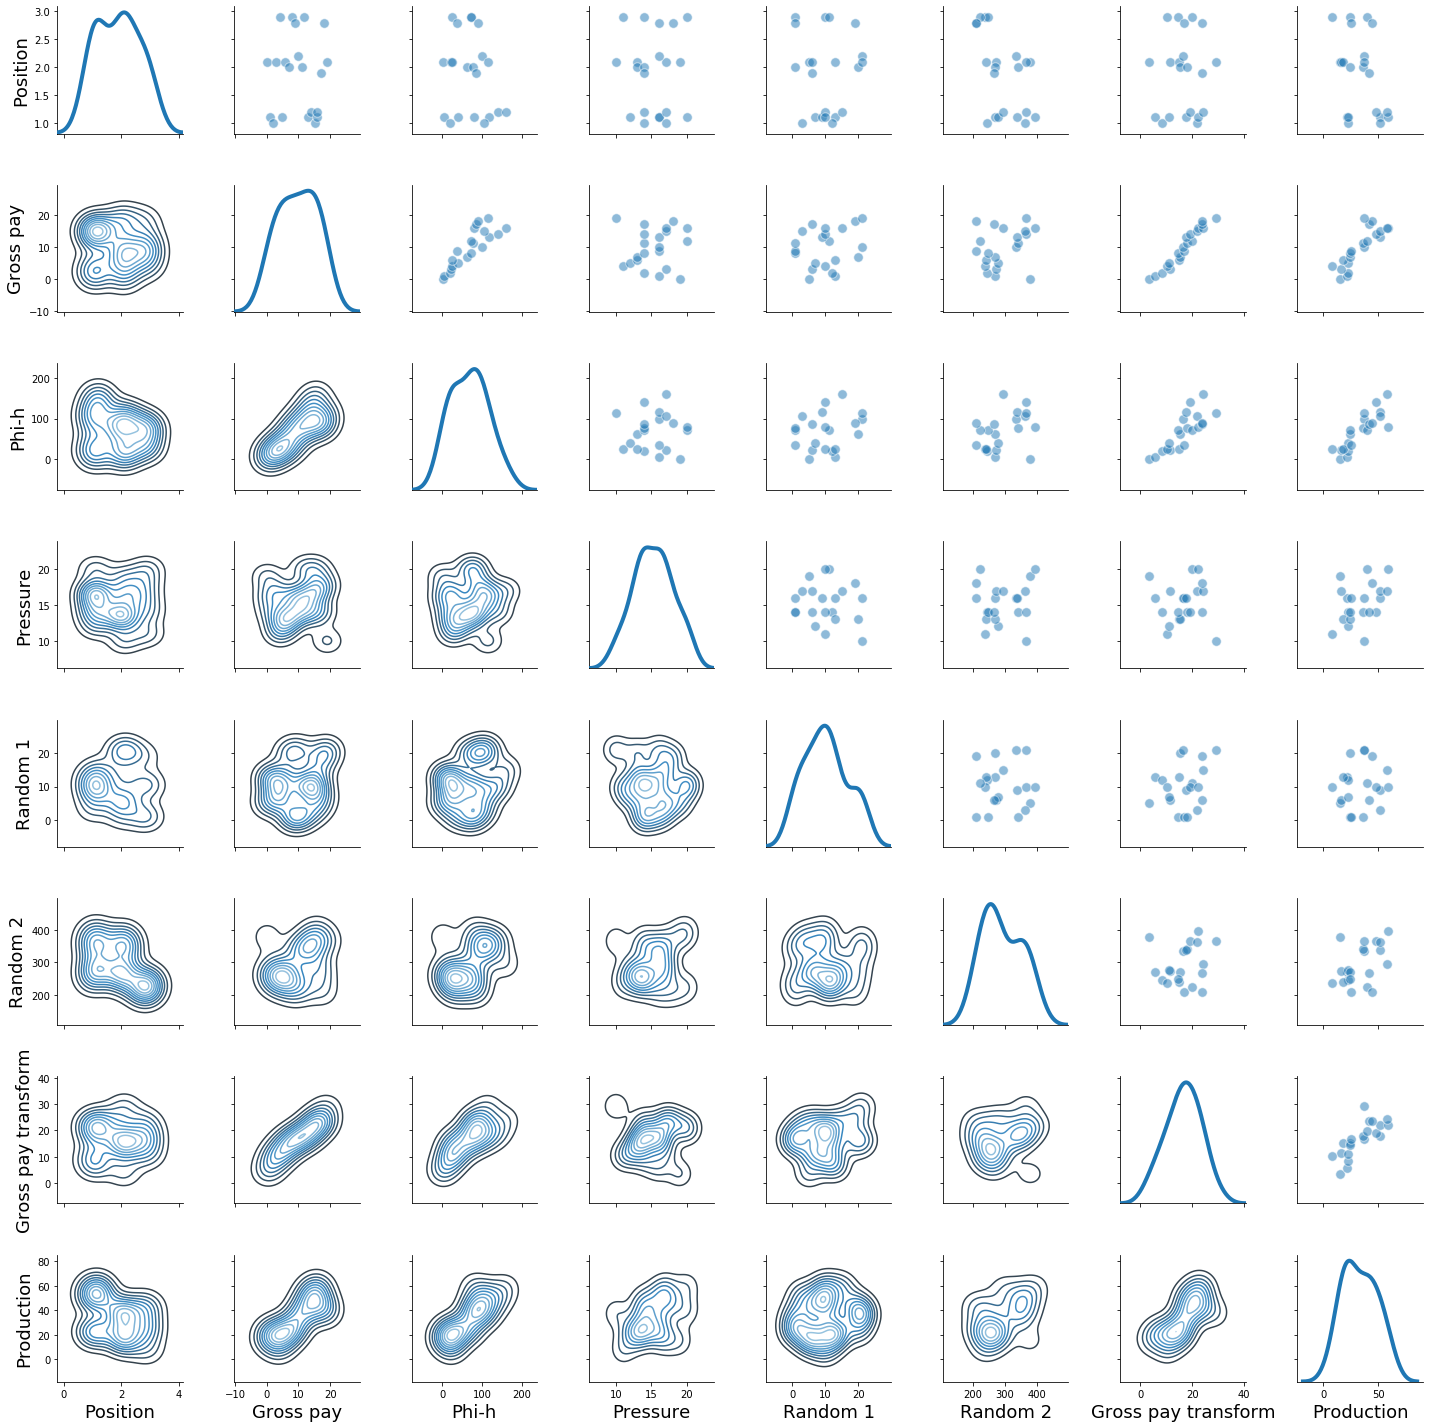

In [9]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
#g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

#plt.savefig('Matrix_initial.png', dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Preliminary observations:
-  Position (ranked position within the reservoir) seems to be a very important variable nothwidstanding the significance tests. Indeed, Gross-pay, Phi-h, Pressure, and Production all cluster according to position in three separate groups.
- Linear relationships with Production: Gross pay and Phi-h and Production, both with high correlation coefficients; Pressure, with more scatter and lower correlation coefficient, perhaps Random 2. 
- Linear relationships amongst independent variables: Gross with Phi-h, and Gross pay with its transform.


In [10]:
from matplotlib import rc
font = {'size'   : 18}
rc('font', **font)

## Part 2 - when is a correlation significant?

### 2a - Kalkomey's probability of spuriousness

In the context of a single (seismic) attribute, for example P-impedance, as a possible predictor of a reservoir porperty, for example porosity,  **Kalkomey (1997, Reference 3)** defined spuriousness as the probability of observing the absolute value of the sample correlation, r, being greater than some constant, R, given the true (population) correlation ρ is zero is given by:

\begin{equation*}
p_{sc} = Pr (|r|>= R)= Pr \Bigl( |t| >= \frac{R \sqrt{n-2}}{\sqrt{1-R^2}} \Bigr)
\end{equation*}

where n is the sample size or number of locations (the wells) with measurements of both the reservoir property and the seismic attribute, and t is the Student’s t distribution with n-2 degrees of freedom.

This probability of spuriousness psc is the same as the well-known p-value, and we can rephrase the above as per my definition of p-value: p it is the probability of getting a sample with at least the correlation coefficient we just got or even higher, purely by chance.

With multiple independent attributes, the probability of observing at least one spurious correlation when considering a set of k independent attributes is simply 1 minus the probability that none of the sample correlations are spurious, which is equivalent to the summation:

\begin{equation*}
1-(1-p_{sc})^{k} =  \sum_{i=1}^k  p_{sc}(1-p_{sc})^{(i-1)}
\end{equation*}

where 

\begin{equation*}
p_{sc}(1-p_{sc})^{(i-1)}
\end{equation*}

is the penalty for increasing the number of attributes considered from k-1 to k.

#### The function below calculates psc

It is an implementation of the summation above.

In [11]:
def P_spurious (r, nwells, nattributes):
    t_of_r = r * np.sqrt((nwells-2)/(1-np.power(r,2)))  
    p = sp.stats.t.sf(np.abs(t_of_r), nwells-2)*2 
    ks = np.arange(1, nattributes+1, 1)
    return np.sum(p * np.power(1-p, ks-1))

Notice that the probability of spuriousness depends solely on the number of independent attributes, the number of wells n and the magnitude R of the spurious sample correlation.

#### Replicating Table 3 from Kalkomey's paper: psc with 10 attributes

We define a range for the number of wells and for the constant R, the magnitude of the spurious sample correlation. 

In [12]:
nrs = np.arange(0.1, 1, 0.1).round(decimals=2) # to avoid odd tick label problem
wells= np.asarray([5, 10, 15, 20, 25, 35, 50, 75, 100])

We define the number of attributes.

In [13]:
na = 10

In [14]:
ps = np.asarray([P_spurious(R, nw, na)  for R in nrs for nw in wells]).reshape(9,9)

In [15]:
psdf = pd.DataFrame(ps, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

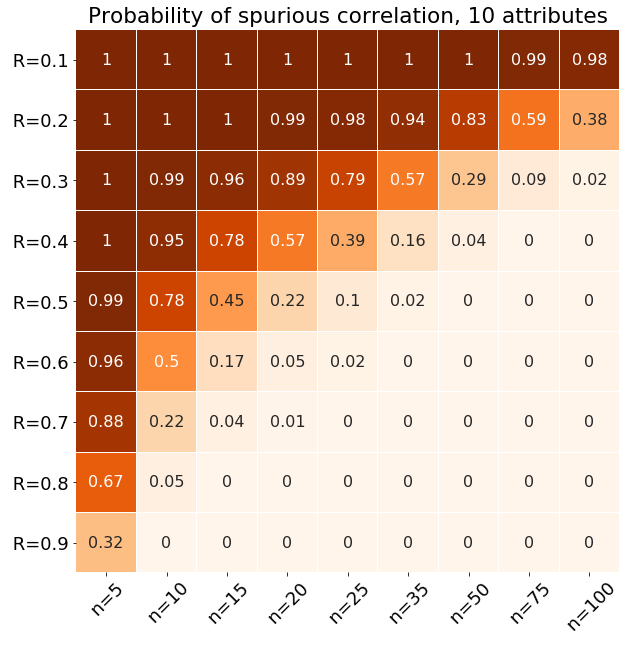

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(psdf, annot=True, annot_kws={"size": 16}, cmap='Oranges', square=True, linewidths=0.01, cbar=False)
plt.yticks(rotation=0) 
plt.xticks(rotation=45)
plt.title('Probability of spurious correlation, 10 attributes')
ax.set_ylim(psdf.shape[0]-0.01, -0.01)
#plt.savefig('Kalcomey_T3.png', dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

##### Replicating Table 1 from Kalkomey's paper: psc with 1 attribute

When there is only one attribute the probability of spuriousness depends only on the number of wells n and the magnitude R of the spurious sample correlation.

In [17]:
na = 1

In [18]:
ps = np.asarray([P_spurious(R, nw, na)  for R in nrs for nw in wells]).reshape(9,9)

In [19]:
psdf = pd.DataFrame(ps, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

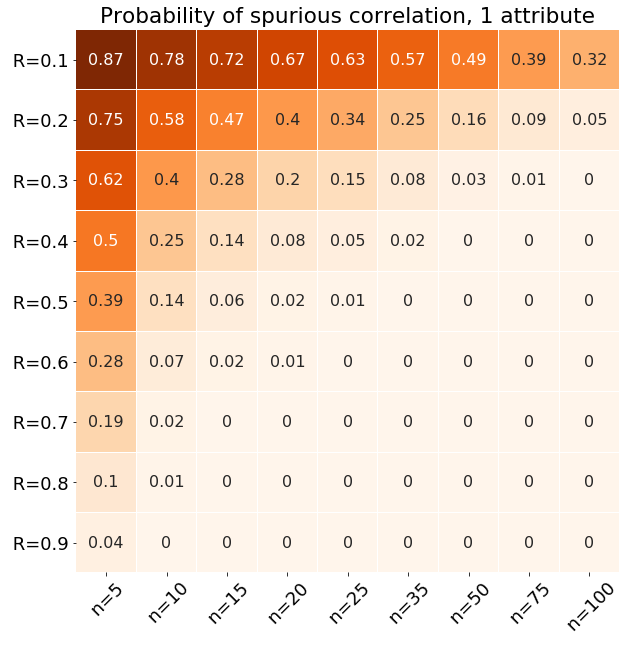

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(psdf, annot=True,annot_kws={"size": 16}, cmap='Oranges', square=True, linewidths=0.01, cbar=False)
plt.yticks(rotation=0) 
plt.xticks(rotation=45)
plt.title('Probability of spurious correlation, 1 attribute')
ax.set_ylim(psdf.shape[0]-0.01, -0.01)
#plt.savefig('Kalcomey_T1.png', dpi=400, bbox_inches='tight', pad_inches=0.1)
plt.show()

**So, for example, with 10 wells and a correlation coefficient CC=0.4 between impedance and porosity (so we're comparing against R = 0.4), theres a 25% probability, or 1 in 4 chances, that the correlation is spurious.**

#### Showing the dependence of psc on the number of wells and the magnitude of the spurious sample correlation, for 1 attribute

We do this by plotting together the left-most 4 columns of the last table.

In [21]:
nrs = np.arange(0, 1, 0.05).round(decimals=2)
wells= np.arange(5, 23, 1)

In [22]:
ps = np.asarray([P_spurious(R, nw, 1)  for R in nrs for nw in wells]).reshape(20,18)
psdf = pd.DataFrame(ps, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

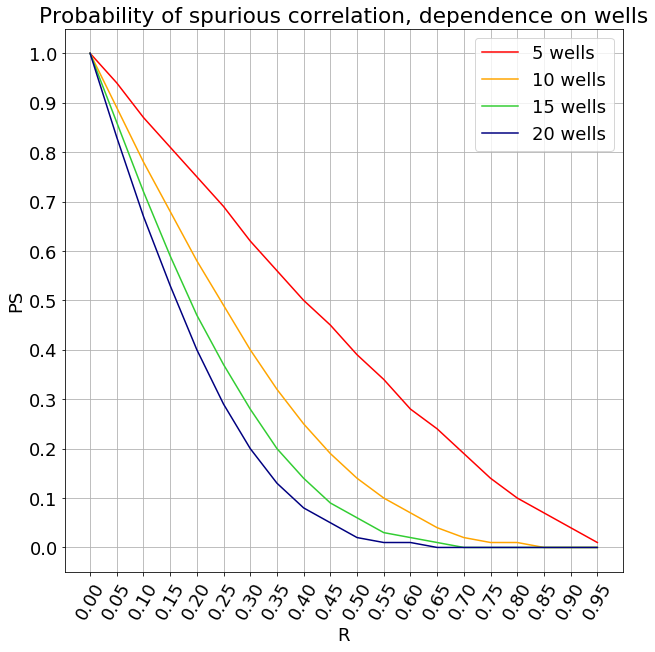

In [23]:
fig = plt.subplots(figsize=(10, 10))
plt.plot(nrs, psdf[' n=5'], 'r', label = '5 wells')
plt.plot(nrs, psdf[' n=10'], 'Orange', label = '10 wells')
plt.plot(nrs, psdf[' n=15'], 'limegreen', label = '15 wells')
plt.plot(nrs, psdf[' n=20'], 'navy', label = '20 wells')
plt.xticks(np.arange(0, 1, 0.05).round(decimals=2), rotation = 60)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.ylabel('PS')
plt.xlabel('R')
plt.title('Probability of spurious correlation, dependence on wells')
plt.grid()
plt.legend();
#plt.savefig('Kalcomey_PS_wells.png', dpi=400, bbox_inches='tight', pad_inches=0.1);

With R = 0.85 - the sample correlation coefficient between Production and Gross pay -  and 20 wells, 15 wells, or even 10 wells the probability of spuriousness is 0; even with just 5 wells it would be only 6.8% or about 1 in 15.

BUt with R = 0.38 - the sample correlation coefficient between Production and Pressure drawdown - the probability of spuriousness with 20 wells is 9%; with 15 wells it is 16%; with 10 wells it is 28% (already greater than 1 in 4 chances); with 5 wells it is 53%, or 1 chance in 2.

This does not mean that we should not use Pressure to estimate Production. I certainly would have not a lot of confidence in using it as a sole predictor of Production  but because we are testing a hypothesis based on physical expectations (through Darcy's Law, as pointed out by Lee Hunt) I would use it in a multivariate estimation of Production. Things would be different had this been an unknown variable without a hypotesing explaining the relationship: this is where the domain knowledge comes into play.



#### Showing the dependence of psc on the number of attributes

In [24]:
ps1 = np.asarray([P_spurious(R, nw, 1)  for R in nrs for nw in wells]).reshape(20,18)
psdf1 = pd.DataFrame(ps1, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

ps2 = np.asarray([P_spurious(R, nw, 2)  for R in nrs for nw in wells]).reshape(20,18)
psdf2 = pd.DataFrame(ps2, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

ps4 = np.asarray([P_spurious(R, nw, 4)  for R in nrs for nw in wells]).reshape(20,18)
psdf4 = pd.DataFrame(ps4, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

ps8 = np.asarray([P_spurious(R, nw, 8)  for R in nrs for nw in wells]).reshape(20,18)
psdf8 = pd.DataFrame(ps8, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

ps16 = np.asarray([P_spurious(R, nw, 16)  for R in nrs for nw in wells]).reshape(20,18)
psdf16 = pd.DataFrame(ps16, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

ps32 = np.asarray([P_spurious(R, nw, 32)  for R in nrs for nw in wells]).reshape(20,18)
psdf32 = pd.DataFrame(ps32, index = [" R=" + mp for mp in map(str, nrs)], 
                  columns = [" n=" + mp for mp in map(str, wells)]).round(decimals=2)

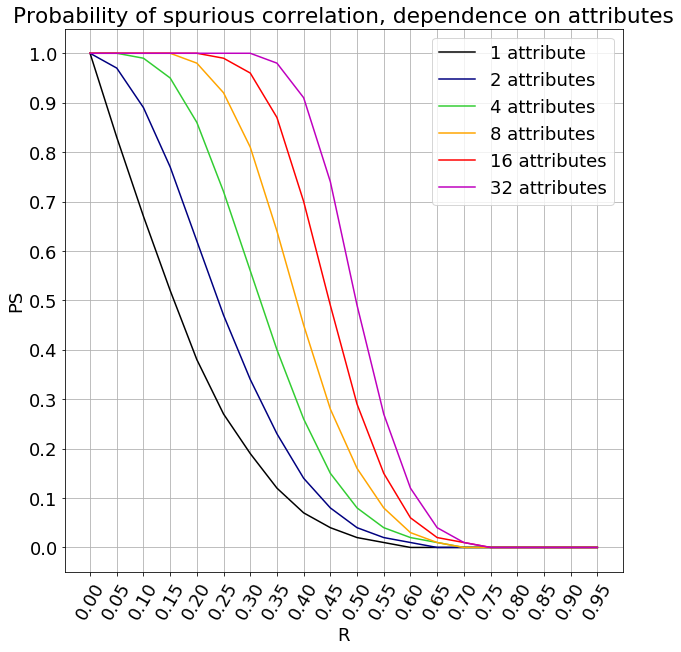

In [25]:
fig = plt.subplots(figsize=(10, 10))
plt.plot(nrs, psdf1[' n=21'], 'k', label = '1 attribute')
plt.plot(nrs, psdf2[' n=21'], 'navy', label = '2 attributes')
plt.plot(nrs, psdf4[' n=21'], 'limegreen', label = '4 attributes')
plt.plot(nrs, psdf8[' n=21'], 'Orange', label = '8 attributes')
plt.plot(nrs, psdf16[' n=21'], 'r', label = '16 attributes')
plt.plot(nrs, psdf32[' n=21'], 'm', label = '32 attributes')
plt.xticks(np.arange(0, 1, 0.05).round(decimals=2), rotation = 60)
plt.yticks(np.arange(0, 1.05, 0.1))
plt.ylabel('PS')
plt.xlabel('R')
plt.title('Probability of spurious correlation, dependence on attributes')
plt.grid()
plt.legend();
#plt.savefig('Kalcomey_PS_attributes.png', dpi=400, bbox_inches='tight', pad_inches=0.1);

For example, suppose we had 21 wells and used 2 attributes to predict Production, there would be a probability of 8% of observing a sample correlation coefficient of 0.45 for at least one of the attributes, when no correlation actually existed between the attributes and Production.
The probability would go up to 15% for at least 1 out of 4 attributes, 28% for at least 1 out of 8, and so on.. 

### 2b - Critical r test

This test will give the value of correlation coefficient (critical correlation coefficient) above which one can rule out chance as an explanation for the relationship in the sample.

In [26]:
def r_crit(nwells, a):
    # a is equal to alpha/2, where alpha is the level of significance,
    # the complement of the confidence level
    t = sp.stats.t.isf(a, nwells-2) # nwells-2 is the degrees of freedom
    r_crit = t/np.sqrt((nwells-2)+ np.power(t,2))
    return r_crit

It is a useful test in its own right. For example, with our 21 wells, and confidence level of 95% (alpha/2 = 0.025), we see that the critical r is 0.433:

In [27]:
print (r_crit(21, 0.025))

0.4328575563165211


Based on this test alone, one can argue that the correlation coefficients between Production and both Gross pay and Phi-h are significant (that is not due to chance); we cannot reach the same conclusion for Position, Pressure, Random 1, and Random 2. 

However, I find it more interesting to look at it in combination with the confidence interval for the population correlation coefficient, as shown in the next section.

### 2c - Confidence interval for the population correlation coefficient

Another question we might ask, with a given number of wells and the sample correlation coefficient, is: "_what is the 95% confidence interval for the correlation coefficient in the population?_"

And here's a convenient function to calculate that confidence interval, which I implemented following [Brown](http://brownmath.com/stat/correl.htm#CI).

In [28]:
def confInt(r, nwells):
    z_crit = sp.stats.norm.ppf(.975) # critical z (confidence  
                                     # interval bounded by +/- z)
    std_Z = 1/np.sqrt(nwells-3)      # std dev of Fisher Z 
    E = z_crit*std_Z                 # error of the estimate
    Z_star = 0.5*(np.log((1+r)/(1.0000000000001-r))) #Fisher Z
    ZCI_l = Z_star - E
    ZCI_u = Z_star + E               # confidence interval for Z
    RCI_l = (np.exp(2*ZCI_l)-1)/(np.exp(2*ZCI_l)+1) 
    RCI_u = (np.exp(2*ZCI_u)-1)/(np.exp(2*ZCI_u)+1)
    return RCI_u, RCI_l              # # confidence interval for ρ

A quick test to ensure we are getting same result as [Brown's example](http://brownmath.com/stat/correl.htm#CI):

In [29]:
print (round(confInt(0.84, 25)[0], 3), round(confInt(0.84, 25)[1], 3))

0.927 0.666


One way I use this function is to create a set of confidence intervals for the population correlation coefficient as a function of the observed sample correlation coefficient from 0 to 1, in increments of 0.5, and turn the result in a heatmap.

Let's create the heatmap, then discuss the insights.
I will use 21 wells as per our dataset.

In [30]:
crr = np.arange(0.0,1.05,0.05).round(decimals=2)
cm21 = np.asarray(confInt(crr, 21)) 

Notice above that the function takes directly arrays as parameters, thanks to NumPy broadcasting.

In [31]:
CI21 = pd.DataFrame(cm21, index = ['CI_UPPER', 'CI_LOWER'], 
                    columns = [" r = " + mp for mp in map(str, crr)])

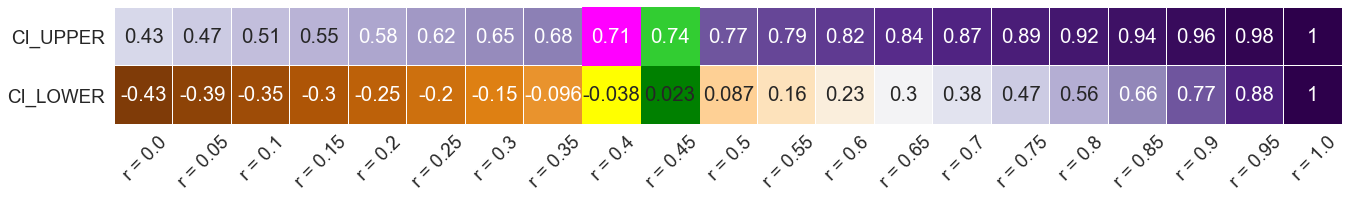

In [32]:
sns.set(font_scale=1.7)
fig, ax = plt.subplots(figsize=(22, 4))
h = sns.heatmap(CI21, annot=True, cmap='PuOr', square=True, linewidths=0.01, cbar=False)
plt.xticks(rotation=45)
h.add_patch(Rectangle((8,0), 1, 1, fill=True, color = 'magenta')) 
h.add_patch(Rectangle((8,1), 1, 1, fill=True, color = 'yellow')) 
h.add_patch(Rectangle((9,0), 1, 1, fill=True, color = 'limegreen')) 
h.add_patch(Rectangle((9,1), 1, 1, fill=True, color = 'green'))
ax.set_ylim(CI21.shape[0]-0.01, -0.01);
#plt.savefig('CI_heatmap_21.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

This tells us a bit more than just the critical r test. 

We see that for the correlation of ** Production and Gross Pay (sample cc = 0.85)**, the 95% confidence interval for the population correlation coefficient is 0.66-0.94 (not bad!). On the other hand, for the correlation of ** Production and Pressure (sample cc = 0.38)** the lower confidence limit is below zero, which means we cannot confidently reject the hypothesis that there is no linear association between Pressure and Production in the population. 

**N.B.** This DOES NOT imply that there isn’t a linear association between Pressure and Production, though; it just means that with the available data we can’t reach a conclusion either way, and more data points are needed. 

There's another interesting point that we can take home, follwing a similar discussion in  Chambers and Yarus (2002, Reference 4), which is that it that from this heatmap we can evince it would take at least a correlation coefficient of 0.45 (the critical r = 0.43, with a bit of rounding) for a correlation to have both upper and lower confidence limits positive; **BUT** even then, the lower confidence limit would still only be 0.023.

It is interesting to see what happens with fewer wells, say 5.

In [33]:
cm5 = np.asarray(confInt(crr, 5))

In [34]:
CI5 = pd.DataFrame(cm5, index = ['CI_UPPER', 'CI_LOWER'], columns = [" r = " + mp for mp in map(str, crr)])

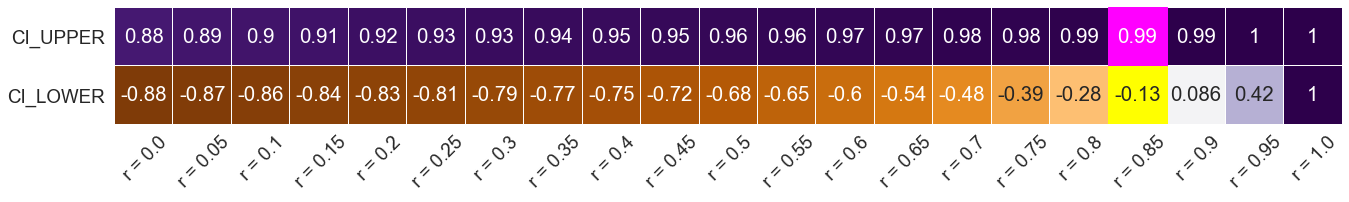

In [35]:
sns.set(font_scale=1.7)
fig, ax = plt.subplots(figsize=(22, 4))
h = sns.heatmap(CI5, annot=True, cmap='PuOr', square=True, linewidths=0.01, cbar=False)
plt.xticks(rotation=45)
h.add_patch(Rectangle((17,0), 1, 1, fill=True, color = 'magenta')) 
h.add_patch(Rectangle((17,1), 1, 1, fill=True, color = 'yellow')) 
ax.set_ylim(CI5.shape[0]-0.01, -0.01);
#plt.savefig('CI_heatmap_5.png', dpi=400, bbox_inches='tight', pad_inches=0.1)

__NB: With only 5 wells even Gross Pay does not pass this test!!__

## Part 3 - revised data visualization

#### Visualization with a more informative custom correlation matrix

So, here’s my ideal first visualization of data:

- the correlation coefficient is coloured green if it is larger than the critical r, else coloured in purple
- the confidence interval is coloured green if both lower and upper are larger than the critical r, else coloured in purple
- the probability of spurious corrrelation is coloured in green when below 0.05 (or 5% chance)

In [36]:
r_crit21 = r_crit(21, 0.025)

In [37]:
def corrfunc(x, y, rc = r_crit21, **kws):
    r, p = sp.stats.spearmanr(x, y)
    u, l = confInt(r, 21)  
    if r > rc:
       rclr = 'g'
    else:
        rclr= 'm' 
    if p > 0.05:
       pclr = 'm'
    else:
        pclr= 'g'
    ax = plt.gca()
    ax.annotate("CC = {:.2f}".format(r), xy=(.1, 1.25), xycoords=ax.transAxes, color = rclr, fontsize = 14)
    ax.annotate("CI = [{:.2f} {:.2f}]".format(u, l), xy=(.1, 1.1), xycoords=ax.transAxes, color = rclr, fontsize = 14)
    ax.annotate("PS = {:.3f}".format(p), xy=(.1, .95), xycoords=ax.transAxes, color = pclr, fontsize = 14)

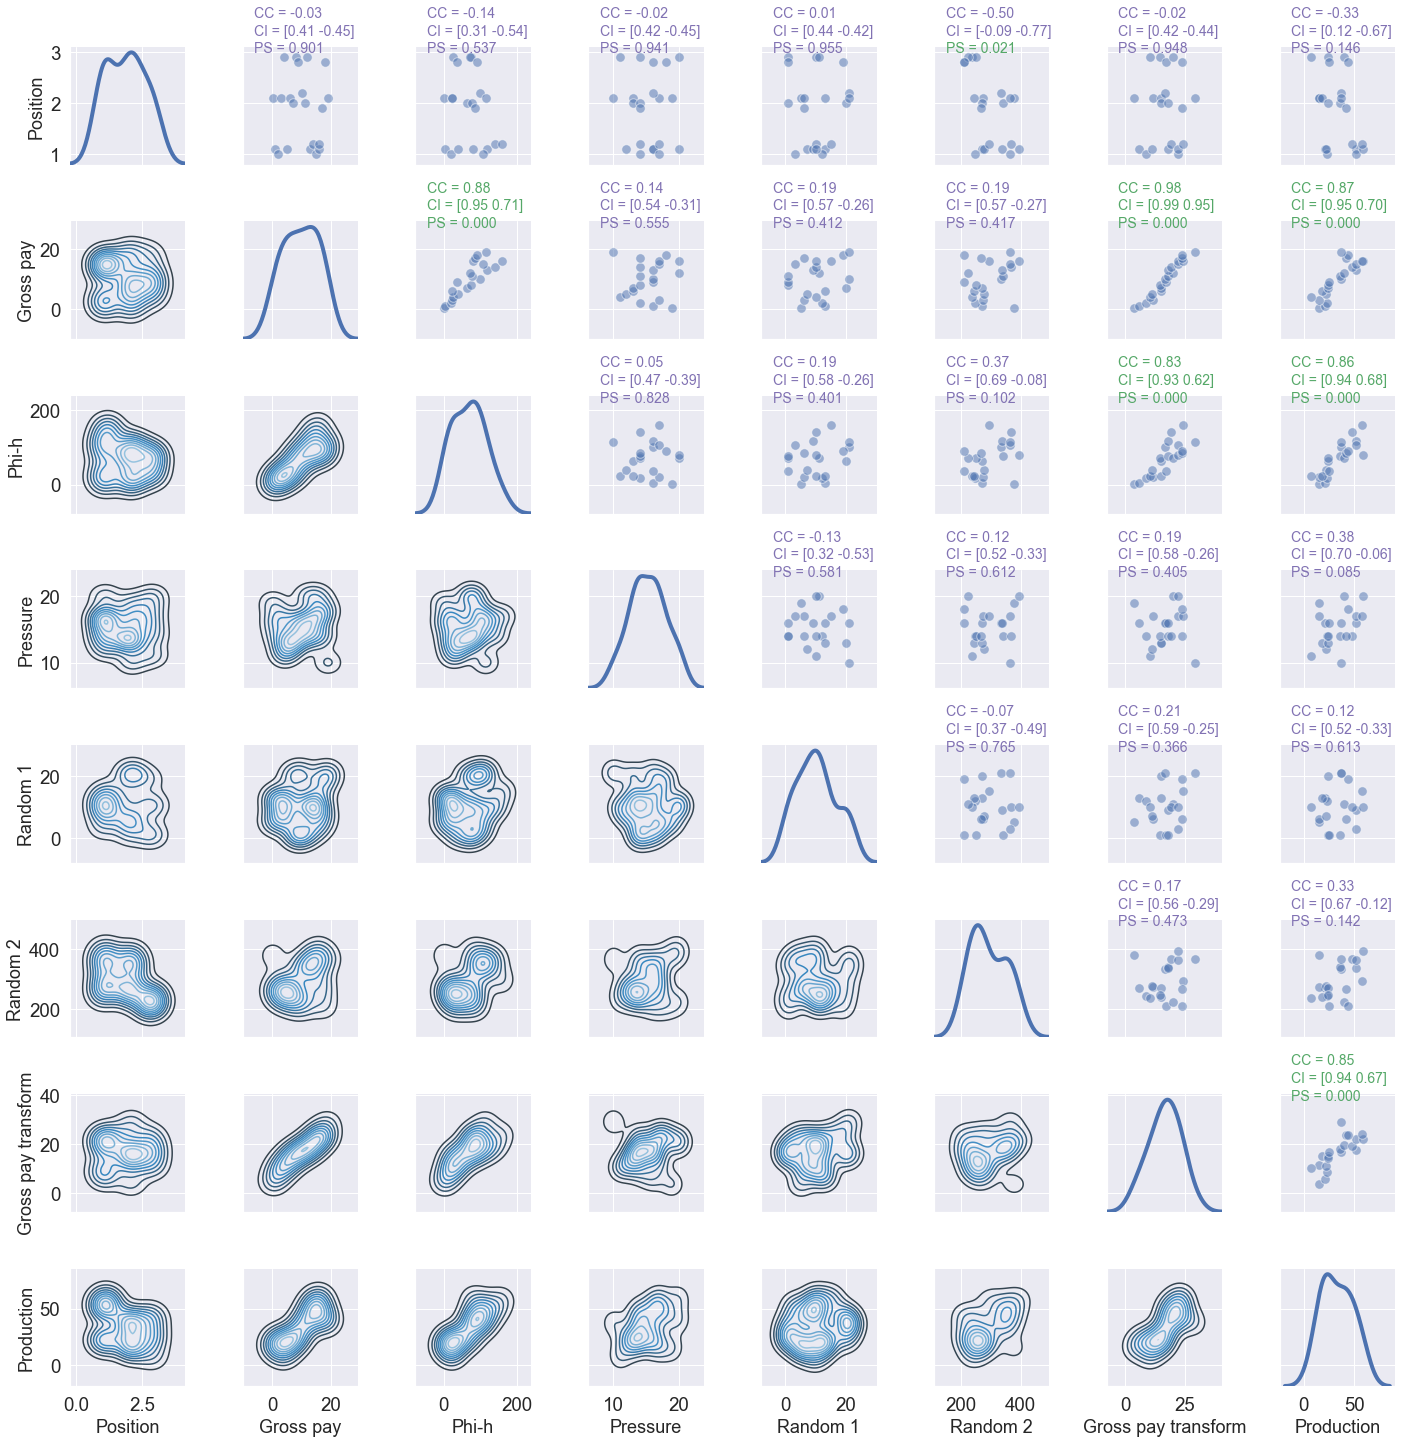

In [38]:
plt.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(data, diag_sharey=False)
axes = g.axes

g.map_upper(plt.scatter,  linewidths=1, edgecolor="w", s=90, alpha = 0.5)
g.map_upper(corrfunc)

g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")

#plt.savefig('matrix_final.png', dpi=500, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Definitions

I created this list of hypothesis testing definitions drawing primarily from Stan Brown's<a href="http://brownmath.com/swt/"> Stats without tears</a>, and secondarily form the reference papers below.

For a sample n of measurements (observations) of variable x and variable y, with a linear correlation coefficient, r = 0.5. ρ is the correlation in the population we are trying to make inferences on.

- **null hypothesis**: ρ = 0, the correlation in the population is zero, there is no linear relationship between the two variables. Our sample with its correlation coefficient r was just the luck of the draw.
- **critical r**: the value of the correlation coefficient at which you can rule out chance as an explanation for the relationship in the sample.
- **significance level, alpha**: the chance of being wrong that one accepts to live with; 0.05, or 5%, is a typical choice.
- **degrees of freedom, df**: the number of observations minus the number of parameters to be estimated. In regression, because one observation is spent to estimate the slope, and one to estimate the intercept, df = n-2.
- **p-value**: the probability of getting a sample with at least the correlation coefficient one just got, or even higher, purely by chance. If the p-value is small, the sample is in conflict with the null hypothesis. If the p-value is large, one can reach no conclusions about the population, and cannot reject the null hypothesis. p-value is the same as the **probability of spurious correlation** defined in **Kalkomey**.
- **type I error**: rejecting the null hypothesis when it is actually true, e.g. using the sample to infer a non existing relationship in the population. This is the most costly type of error, leading to an inaccurate prediction with confidence, as described in both **Kalkomey** and **Chambers and Yarus**.
- **type II error**: this error conversely occurs when a real correlation exists in the population but we fail to use the predictor. Type II errors are not as bad as Type I errors because they result in more uncertainty than justified, as opposed to inaccurate prediction with confidence.

## References

1) <a href="http://csegrecorder.com/features/view/value-of-integrated-geophysics-201312"> Many correlation coefficients, null hypoteses, and high value.</a> Lee Hunt, CSEG Recorder, December 2013.

2) <a href="http://csegrecorder.com/articles/view/too-many-seismic-attributes"> Too many seismic attributes?</a> Arthur Barnes, CSEG Recorder, March 2006.


3) <a href="http://library.seg.org/doi/abs/10.1190/1.1437610"> Potential risks when using seismic attributes as predictors of reservoir properties.</a> Cynthia Kalkomey, The Leading Edge, March 1997.

4) <a href="http://csegrecorder.com/articles/view/too-many-seismic-attributes"> Quantitative use of seismic attributes for reservoir characterization.</a>  Richard Chambers and Jeffrey Yarus, CSEG Recorder, June 2002.